# Lab 1

## Part 2: Neural Machine Translation in the wild
In the second part of the homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.
* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* or just fine-tunning BERT)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [0]:
! pip  install subword-nmt
! pip install nltk
! pip install torchtext==0.5.0
! pip install transformers
# ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

     |████████████████████████████████| 81kB 2.3MB/s 
     |████████████████████████████████| 1.0MB 7.8MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1
     |████████████████████████████████| 573kB 2.8MB/s 
     |████████████████████████████████| 3.7MB 51.5MB/s 
     |████████████████████████████████| 890kB 46.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=058c2ffbf400cbe9c4b65429e73cf846a5a10b0f49c74e002ea13b5a9cbfe347
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd ./'My Drive'
%cd Course_repos/ml_mipt_2019/homeworks_advanced/Lab1_NLP/Transformer

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/My Drive
/gdrive/My Drive/Course_repos/ml_mipt_2019/homeworks_advanced/Lab1_NLP/Transformer


# New Section

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time
import tqdm

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from torchtext.data.metrics import bleu_score
from nltk.translate.bleu_score import corpus_bleu

In [0]:
SEED = 1984

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Main part

### Utils
__Useful functions__

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [0]:
device

device(type='cuda')

In [0]:
def _len_sort_key(x):
    return len(x.src)

In [0]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        print("number of batch: ", i)
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:, :-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()

        #scheduler.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:, :-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
def remove_tech_tokens(mystr, tokens_to_remove=['[SEP]', '[CLS]', '[UNK]', '[PAD]']):
    return [x for x in mystr if x not in tokens_to_remove]

def get_text(x, TRG_vocab):
    tech_idx = [TRG_vocab[x] for x in ['<sos>', '<unk>', '<pad>']]
    eos_idx = TRG_vocab['<eos>']
    text = []
    for idx in x:
        if idx in tech_idx:
            continue
        elif idx == eos_idx:
            break
        else:
            text.append(TRG_vocab.itos[idx])

    if len(text) < 1:
        text = []
    return text

In [0]:
def translate_sentence(src_indexes, TRG_vocab, model, device, max_len = 150):
    
    model.eval()

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src, _ = model.encoder(src_tensor, src_mask)

    trg_indexes = [TRG_vocab.vocab.stoi[TRG_vocab.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1].item()
        
        if pred_token == TRG_vocab.vocab.stoi[TRG_vocab.eos_token]:
            break

        trg_indexes.append(pred_token)
    
    trg_tokens = [TRG_vocab.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [0]:
def translate_sentence_batch(src_indexes, TRG_vocab, model, device, max_len = 150):
    
    model.eval()

    batch_size = src_indexes.shape[0]

    src_tensor = src_indexes.to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src, _ = model.encoder(src_tensor, src_mask)

    trg_indexes = torch.LongTensor([TRG_vocab.vocab.stoi[TRG_vocab.init_token]]).unsqueeze(0).repeat(batch_size, 1).to(device)

    src_mask = src_mask.unsqueeze(1).unsqueeze(2)
    eos_mask = torch.tensor(False).unsqueeze(0).repeat(batch_size).to(device)

    for i in range(max_len):

        trg_mask = model.make_trg_mask(trg_indexes)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_indexes, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1]
        pred_eos = (pred_token == TRG_vocab.vocab.stoi[TRG_vocab.eos_token])

        eos_mask = eos_mask | pred_eos
        if eos_mask.all():
            break
        
        trg_indexes = torch.cat((trg_indexes, pred_token.unsqueeze(1)), dim = 1)
    
    return trg_indexes[:, 1:]

### Transformer

We will try to implement and then evalute performance of the most popular and powerful type of models right now - Transformers. As example of such models we will take ruBERT, implementation of BERT pretrained on russian corpora by guys from DeepPavlov and build up decoder for him. Structure of decoder follows concept from paper "Attention is all you need".


In [0]:
from transformers import BertTokenizer, BertModel, BertConfig

tokenizer_ru = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [0]:
pad_index_ru = tokenizer_ru.convert_tokens_to_ids(tokenizer_ru.pad_token)

SRC = Field(use_vocab=False,
            tokenize=tokenizer_ru.encode,
            pad_token=pad_index_ru,
            batch_first=True)

TRG = Field(tokenize="spacy",
            tokenizer_language="en",
            init_token = '<sos>', 
            eos_token = '<eos>',
            batch_first=True,
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='/gdrive/My Drive/Course_repos/ml_mipt_2019/homeworks_advanced/Lab1_NLP/data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
TRG.build_vocab(train_data, min_freq = 2)

In [0]:
bert_ru = BertModel.from_pretrained("DeepPavlov/rubert-base-cased",
                                    output_attentions = False,
                                    output_hidden_states = False)

In [0]:
for param in bert_ru.parameters():
    param.requires_grad = False

In [0]:
#import importlib
#importlib.reload(tr)
import bert_transformer as tr
Seq2Seq = tr.Seq2Seq
Decoder = tr.Decoder

OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 768
DEC_LAYERS = 3
DEC_HEADS = 8
DEC_PF_DIM = 1024
DEC_DROPOUT = 0.1
MAX_LEN = 150
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              MAX_LEN)

In [0]:
dec.apply(initialize_weights)

Decoder(
  (tok_embedding): Embedding(10326, 768)
  (pos_embedding): Embedding(150, 768)
  (layers): ModuleList(
    (0): DecoderLayer(
      (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=768, out_features=768, bias=True)
        (fc_k): Linear(in_features=768, out_features=768, bias=True)
        (fc_v): Linear(in_features=768, out_features=768, bias=True)
        (fc_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=768, out_features=768, bias=True)
        (fc_k): Linear(in_features=768, out_features=768, bias=True)
        (fc_v): Linear(in_features=768, out_features=768, bias=True)
        (fc_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (positionwise_fee

In [0]:
model = Seq2Seq(bert_ru, dec, pad_index_ru, TRG_PAD_IDX, device).to(device)

In [0]:
count_parameters(model)

34889046

In [0]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [0]:
from transformers.optimization import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_iterator) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

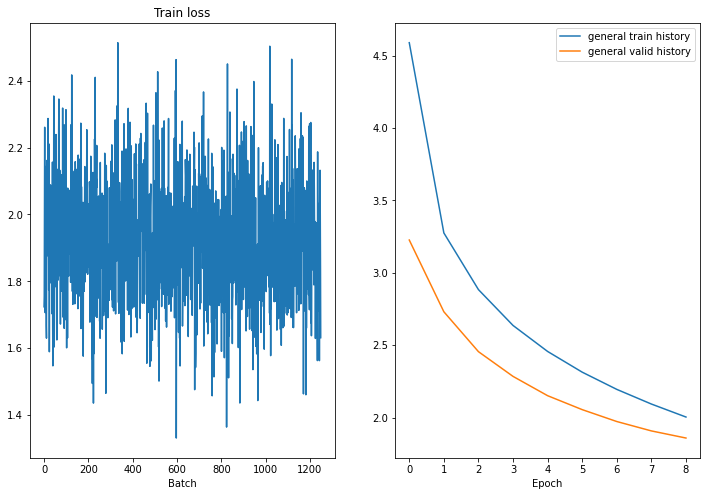

Epoch: 10 | Time: 8m 13s
	Train Loss: 1.926 | Train PPL:   6.860
	 Val. Loss: 1.811 |  Val. PPL:   6.117


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bert_10_epochs_1984.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Again, let's take a look at our network quality__:

In [0]:
it = iter(valid_iterator)

In [0]:
batch = next(it)

In [0]:
example_idx = 103

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = [101, 40174, 13535, 29842, 13967, 6329, 6675, 845, 140, 4220, 1641, 36874, 9095, 11673, 10902, 10725, 851, 32283, 76611, 3359, 49116, 869, 72970, 6951, 2010, 69260, 845, 13309, 851, 80821, 3187, 869, 91319, 54800, 132, 102]
trg = ['just', '2', 'km', 'from', 'pelita', 'commercial', 'centre', ',', 'grand', 'palace', 'offers', 'spacious', 'rooms', 'with', 'flat', '-', 'screen', 'tvs', 'and', 'free', 'wired', 'internet', '.']


In [0]:
translation, attention = translate_sentence(src, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['just', '2', 'km', 'from', 'the', '<unk>', 'shopping', 'centre', ',', 'hotel', '<unk>', 'offers', 'spacious', 'rooms', 'with', 'free', 'wi', '-', 'fi', 'and', 'flat', '-', 'screen', 'tv', '.', '<eos>']


In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = translate_sentence_batch(src, TRG, model, device) #turn off teacher forcing
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy()])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy()])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

235it [03:00,  1.30it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

25.809375012580304

This is beyond any words. Quality is not simply impressive. 
<br>
It's unbelievable.
<br>
Even after only one epoch BLEU-score was 46, and... I don't know what to say more.